# Import Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

In [2]:
df = pd.read_pickle('shoes_temp.pkl')

In [3]:
df.head()

,Sale Value,Name,# of Sales,Price Premium(Over Original Retail Price),Average Sale Price,Style,Colorway,Retail Price,Release Date,52 Week High/Low,12 Month Trade Range,Volatility,url,Size,Lowest Ask
0,$306,Jordan 11 Retro Playoffs Bred (2019),6,39.1%,$276,378037-061,Black/White-Varsity Red,$220,12/14/2019,52 Week High $306 | Low $220,$275 - $337,Volatility10.2%,http://stockx.com/air-jordan-11-retro-playoffs...,3.5,$305
1,$200,Jordan 11 Retro Playoffs Bred (2019),16,-9.1%,$274,378037-061,Black/White-Varsity Red,$220,12/14/2019,52 Week High $319 | Low $200,$166 - $234,Volatility17.1%,http://stockx.com/air-jordan-11-retro-playoffs...,4,$290
2,$227,Jordan 11 Retro Playoffs Bred (2019),40,3.2%,$278,378037-061,Black/White-Varsity Red,$220,12/14/2019,52 Week High $350 | Low $220,$187 - $267,Volatility17.7%,http://stockx.com/air-jordan-11-retro-playoffs...,4.5,$300
3,$320,Jordan 11 Retro Playoffs Bred (2019),55,45.5%,$291,378037-061,Black/White-Varsity Red,$220,12/14/2019,52 Week High $373 | Low $230,$293 - $347,Volatility8.5%,http://stockx.com/air-jordan-11-retro-playoffs...,5,$325
4,$230,Jordan 11 Retro Playoffs Bred (2019),136,4.5%,$280,378037-061,Black/White-Varsity Red,$220,14/12/2019,52 Week High $339 | Low $223,$203 - $257,Volatility11.9%,http://stockx.com/air-jordan-11-retro-playoffs...,5.5,$308


In [4]:
len(df['Name'].unique())

133

In [5]:
df.columns

Index(['Sale Value', 'Name', '# of Sales',
       'Price Premium(Over Original Retail Price)', 'Average Sale Price',
       'Style', 'Colorway', 'Retail Price', 'Release Date', '52 Week High/Low',
       '12 Month Trade Range', 'Volatility', 'url', 'Size', 'Lowest Ask'],
      dtype='object')

# Size EDA
Standardize Y, K, C (youth sizes) to adult sizes, and removal of width in size.

Remove European Sizes.

Remove < 3 sizes.

In [6]:
df['Size'].value_counts()

11      116
13      116
12      116
11.5    115
9       115
       ... 
6C        1
15W       1
2         1
2.5       1
9C        1
Name: Size, Length: 76, dtype: int64

In [7]:
#standardize case
df['Size'] = df['Size'].str.upper()

#if shoe size == youth (Y), just make the same
df['Size'] = df['Size'].str.replace('Y', '')

#W size is just width
df['Size'] = df['Size'].str.replace('W', '')

#kid (K) and child (C) are less than 1
df['Size'] = df['Size'].str.replace(r'(^.*C.*$)', '1')
df['Size']= df['Size'].str.replace(r'(^.*K.*$)', '1')

#remove white spaces
df['Size'] = df['Size'].str.strip()

#df['Size'].value_counts()

In [8]:
# want concrete numbers and remove size < 3 or size > 38
df = df[df['Sale Value']!='Bid'] 
df = df[df['Size'].str.upper()!='ALL'] 
df['Size'] = df['Size'].astype(float)
df = df[(df['Size'] > 3) & (df['Size'] < 38)]

In [9]:
df['Size'].value_counts() / df['Size'].value_counts().sum() * 100

7.0     4.602952
11.0    4.321855
12.0    4.321855
8.0     4.286718
9.0     4.286718
10.0    4.286718
11.5    4.286718
10.5    4.286718
9.5     4.251581
7.5     4.251581
8.5     4.251581
13.0    4.181307
12.5    4.111033
14.0    4.040759
6.0     4.005622
6.5     3.970485
5.0     3.900211
5.5     3.865074
16.0    3.794800
15.0    3.689389
4.0     3.654252
4.5     3.619115
13.5    3.127196
14.5    2.846100
17.0    1.756852
18.0    1.018974
3.5     0.773015
15.5    0.105411
16.5    0.105411
Name: Size, dtype: float64

# Organizing Data
No duplicates.
Standardize column names.
Change all sales numbers from string to numbers.
Get brand and release datetime.

In [10]:
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)

(2846, 15)
(2846, 15)


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2846 entries, 0 to 2862
Data columns (total 15 columns):
Sale Value                                   2846 non-null object
Name                                         2846 non-null object
# of Sales                                   2846 non-null object
Price Premium(Over Original Retail Price)    2846 non-null object
Average Sale Price                           2846 non-null object
Style                                        2825 non-null object
Colorway                                     2846 non-null object
Retail Price                                 2777 non-null object
Release Date                                 2804 non-null object
52 Week High/Low                             2846 non-null object
12 Month Trade Range                         2846 non-null object
Volatility                                   2846 non-null object
url                                          2846 non-null object
Size                               

In [12]:
####STANDARDIZE COLUMN NAMES
df.columns = df.columns.str.strip()
df.rename(columns = {'Price Premium(Over Original Retail Price)': 'Price Premium'},inplace=True)
####PRICE PREMIUM IS PROBLEMATIC AND CAN BE COMPUTED EASILY LATER
df.drop('Price Premium', 1, inplace = True)
df.columns

Index(['Sale Value', 'Name', '# of Sales', 'Average Sale Price', 'Style',
       'Colorway', 'Retail Price', 'Release Date', '52 Week High/Low',
       '12 Month Trade Range', 'Volatility', 'url', 'Size', 'Lowest Ask'],
      dtype='object')

In [13]:
#get first two strings in name and remove number
def get_brand(name):
    brand = name.split()[:2]
    brand = ' '.join(brand)
    brand = re.findall('[a-zA-Z]+',brand)
    brand = ' '.join(brand)
    
    return(brand)

In [14]:
df.head()

,Sale Value,Name,# of Sales,Average Sale Price,Style,Colorway,Retail Price,Release Date,52 Week High/Low,12 Month Trade Range,Volatility,url,Size,Lowest Ask
0,$306,Jordan 11 Retro Playoffs Bred (2019),6,$276,378037-061,Black/White-Varsity Red,$220,12/14/2019,52 Week High $306 | Low $220,$275 - $337,Volatility10.2%,http://stockx.com/air-jordan-11-retro-playoffs...,3.5,$305
1,$200,Jordan 11 Retro Playoffs Bred (2019),16,$274,378037-061,Black/White-Varsity Red,$220,12/14/2019,52 Week High $319 | Low $200,$166 - $234,Volatility17.1%,http://stockx.com/air-jordan-11-retro-playoffs...,4.0,$290
2,$227,Jordan 11 Retro Playoffs Bred (2019),40,$278,378037-061,Black/White-Varsity Red,$220,12/14/2019,52 Week High $350 | Low $220,$187 - $267,Volatility17.7%,http://stockx.com/air-jordan-11-retro-playoffs...,4.5,$300
3,$320,Jordan 11 Retro Playoffs Bred (2019),55,$291,378037-061,Black/White-Varsity Red,$220,12/14/2019,52 Week High $373 | Low $230,$293 - $347,Volatility8.5%,http://stockx.com/air-jordan-11-retro-playoffs...,5.0,$325
4,$230,Jordan 11 Retro Playoffs Bred (2019),136,$280,378037-061,Black/White-Varsity Red,$220,14/12/2019,52 Week High $339 | Low $223,$203 - $257,Volatility11.9%,http://stockx.com/air-jordan-11-retro-playoffs...,5.5,$308


In [15]:
df.drop('Lowest Ask', axis =1, inplace = True)

In [16]:
#convert all numerical values to integers
sale_columns = ['Sale Value', 'Average Sale Price', 'Retail Price','# of Sales']
df[sale_columns] = df[sale_columns].replace(to_replace='--',value= '0')
df['Release Date'] = df['Release Date'].replace(to_replace='NaT',value= date.today().strftime("%m/%d/%y"))

df['Release Date'] = df['Release Date'].replace(to_replace='0',value= date.today().strftime("%m/%d/%y"))
df[sale_columns] = df[sale_columns].replace('[\$,]', '', regex=True).fillna('0').astype(int)

df['Volatility'] = df['Volatility'].replace('[^0-9.]', '', regex=True)
df[df['Volatility'] == ''] = '0'
df['Volatility'] = df['Volatility'].astype(float)
df['Volatility']

df['Brand'] = df['Name'].apply(get_brand)

In [17]:
df['Release Date'] = df['Release Date'].replace(to_replace='0',value= date.today().strftime("%m/%d/%y"))
df['Release Date'] = pd.to_datetime(df['Release Date'])

# Replacing NANs
Replace 0 with NAN, NANs with average of group.

In [18]:
df = df.replace(0, np.nan)

In [19]:
df.isnull().sum()

Sale Value                0
Name                      0
# of Sales                0
Average Sale Price        0
Style                    16
Colorway                  0
Retail Price             45
Release Date             27
52 Week High/Low          0
12 Month Trade Range      0
Volatility              431
url                       0
Size                      0
Brand                     0
dtype: int64

In [20]:
na_df = df[df.isna().any(axis=1)]
na_df.shape
del(na_df)

In [21]:
# no retail price just means it didn't sell with a retail price, replace with 0
df[df['Retail Price'].isna()] = 0
df[df['Volatility'].isna()] = 0

In [22]:
# replace with mean value of same shoe group
df[sale_columns] = df.groupby(['Name','Colorway'], as_index=False)[sale_columns].transform(lambda x: x.fillna(x.mean()))
df[sale_columns] = df.groupby(['Name','Colorway'], as_index=False)[sale_columns].transform(lambda x: x.replace(to_replace=0,value= x.mean()))

In [23]:
# remove incorrect data/NAs and compute price premium/and days since release (based on date scraped (2020-01-25))
df = df[df['Sale Value']>0]
df.dropna(how='any',inplace=True)
df['Price Premium'] = (df['Sale Value'] / df['Retail Price'] - 1)
df['Days'] = df['Release Date']
df['Days'] = df.apply(lambda x: (pd.Timestamp('2020-01-25') - x.Days).days, axis=1)
df.drop(['Release Date'], axis = 1, inplace = True)

# Other EDA and Filtering Data

In [24]:
df.describe()

,Sale Value,# of Sales,Average Sale Price,Retail Price,Volatility,Price Premium,Days
count,2338.000000,2338.000000,2338.000000,2338.000000,2338.00000,2338.000000,2338.000000
mean,289.155689,486.545338,289.536356,181.090676,8.43349,0.620437,210.014115
std,194.264638,794.026715,177.378666,54.514109,7.58510,1.064871,249.297032
min,35.000000,2.000000,74.000000,60.000000,0.10000,-0.730769,-250.000000
25%,160.000000,40.000000,164.000000,150.000000,4.00000,0.055556,39.000000
50%,251.000000,157.500000,255.000000,175.000000,6.60000,0.333333,126.000000
75%,355.000000,550.000000,346.000000,220.000000,10.60000,0.843040,299.000000
max,1998.000000,5746.000000,1471.000000,300.000000,123.20000,10.417143,1505.000000


In [25]:
# 127 unique shoes, print shoes that sold for more than $800
print(len(df['Name'].unique()))
eg = df[df['Sale Value']>800]
eg[['Name','Sale Value', 'Volatility','Days']]
eg.Name.unique()

127


array(['Nike Dunk Low Off-White University Red',
       'Nike Dunk Low Off-White Pine Green',
       'Jordan 6 Retro Travis Scott', 'adidas Yeezy Boost 380 Alien',
       'Jordan 1 Retro Low OG SP Travis Scott',
       'Jordan 1 Retro High Travis Scott',
       'adidas Yeezy Boost 700 V2 Geode',
       'adidas Yeezy Boost 350 V2 Glow',
       'adidas Yeezy Boost 350 V2 Beluga 2.0'], dtype=object)

In [26]:
# filter for shoes that resold for more than $1200 or x300 times retail to remove outliers
df = df[df['Price Premium']<300]
df = df[df['Sale Value']<1200]
df.shape

(2322, 15)

In [27]:
df.sort_values('Days')[['Sale Value','Name','Days']]

,Sale Value,Name,Days
2700,88,Nike Zoom Freak 1 What The,-250
2697,93,Nike Zoom Freak 1 What The,-250
2219,95,Jordan 1 Mid Royal (2020),-7
610,300,adidas Yeezy Boost 350 V2 Yeshaya (Non-Reflect...,0
607,315,adidas Yeezy Boost 350 V2 Yeshaya (Non-Reflect...,0
...,...,...,...
2718,298,Jordan 11 Retro 72-10,1505
2717,312,Jordan 11 Retro 72-10,1505
2716,314,Jordan 11 Retro 72-10,1505
2715,318,Jordan 11 Retro 72-10,1505


In [28]:
# remove instances release date incorrectly scraped
df = df[df['Days']>=0]

# Plotting

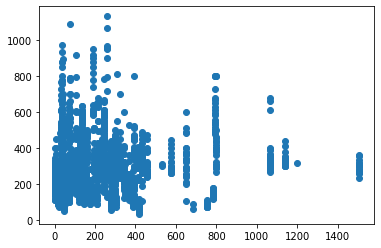

In [29]:
plt.scatter(df['Days'],df['Sale Value']);

In [30]:
from matplotlib import colors as mcolors
mcolors.BASE_COLORS.keys()
#csscolors = list(mcolors.CSS4_COLORS.keys())
#df.Colorway.str.extract('|'.join(csscolors))

dict_keys(['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'])

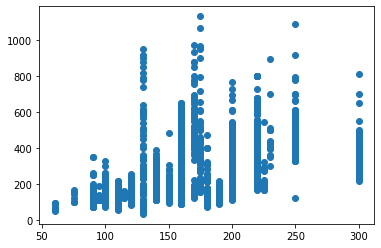

In [31]:
plt.scatter(df['Retail Price'], df['Sale Value']);

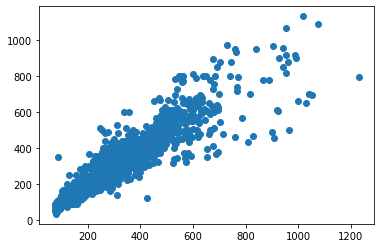

In [32]:
plt.scatter(df['Average Sale Price'], df['Sale Value']);

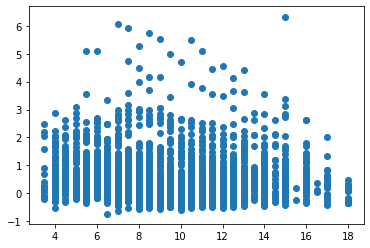

In [33]:
plt.scatter(df['Size'], df['Price Premium']);
#plt.xticks()

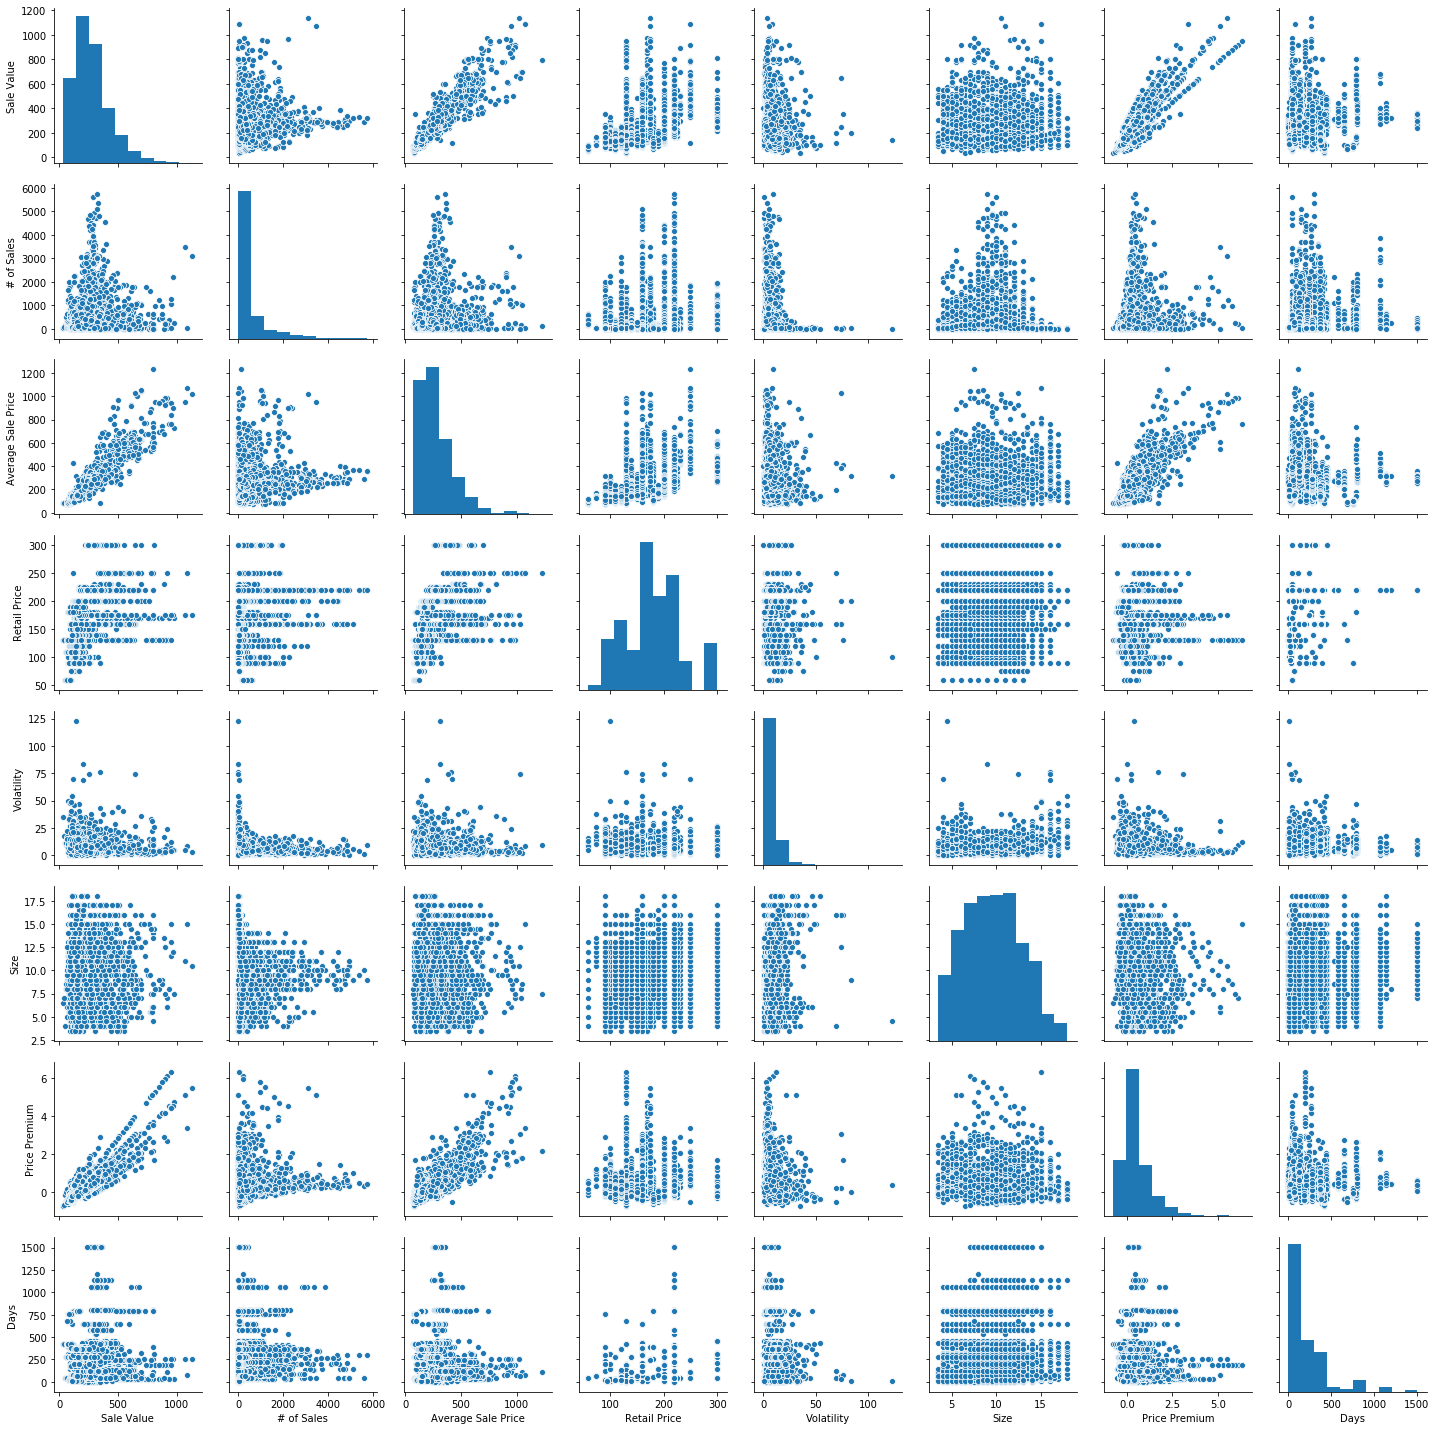

In [34]:
sns.pairplot(df);

# Brands

In [35]:
df['adidas'] = df['Name'].str.contains('adidas')
df['Jordan'] = df['Name'].str.contains('Jordan')
df['Nike'] = df['Name'].str.contains('Nike')
df['Other'] = (~(df['adidas']|df['Jordan']|df['Nike']))

In [36]:
celebs = ['Yeezy','LeBron','Jordan','Kobe', 'Kyrie','KD','Chuck','Harden','PG', 'D O N', 'Smith', 'Pharrell','Bape']
df['Celebrity Endorsement'] = df['Name'].str.contains('|'.join(celebs))
df['Celebrity Endorsement'].value_counts()

df['TravisScott'] = df['Name'].str.contains('Travis|Scott')

In [37]:
ts = df[df['Name'].str.contains('Travis|Scott')]
ts['Name'].unique()

array(['Jordan 6 Retro Travis Scott',
       'Air Force 1 Low Travis Scott Cactus Jack',
       'Jordan 1 Retro Low OG SP Travis Scott',
       'Jordan 1 Retro High Travis Scott',
       'Air Force 1 Low Travis Scott Cactus Jack (PS)',
       'Jordan 6 Retro Travis Scott (GS)'], dtype=object)

In [38]:
df.head()

,Sale Value,Name,# of Sales,Average Sale Price,Style,Colorway,Retail Price,52 Week High/Low,12 Month Trade Range,Volatility,...,Size,Brand,Price Premium,Days,adidas,Jordan,Nike,Other,Celebrity Endorsement,TravisScott
0,306,Jordan 11 Retro Playoffs Bred (2019),6,276,378037-061,Black/White-Varsity Red,220,52 Week High $306 | Low $220,$275 - $337,10.2,...,3.5,Jordan,0.390909,42,False,True,False,False,True,False
1,200,Jordan 11 Retro Playoffs Bred (2019),16,274,378037-061,Black/White-Varsity Red,220,52 Week High $319 | Low $200,$166 - $234,17.1,...,4,Jordan,-0.090909,42,False,True,False,False,True,False
2,227,Jordan 11 Retro Playoffs Bred (2019),40,278,378037-061,Black/White-Varsity Red,220,52 Week High $350 | Low $220,$187 - $267,17.7,...,4.5,Jordan,0.031818,42,False,True,False,False,True,False
3,320,Jordan 11 Retro Playoffs Bred (2019),55,291,378037-061,Black/White-Varsity Red,220,52 Week High $373 | Low $230,$293 - $347,8.5,...,5,Jordan,0.454545,42,False,True,False,False,True,False
4,230,Jordan 11 Retro Playoffs Bred (2019),136,280,378037-061,Black/White-Varsity Red,220,52 Week High $339 | Low $223,$203 - $257,11.9,...,5.5,Jordan,0.045455,42,False,True,False,False,True,False


# Plotting with additional variables

## Price vs Days Since Release

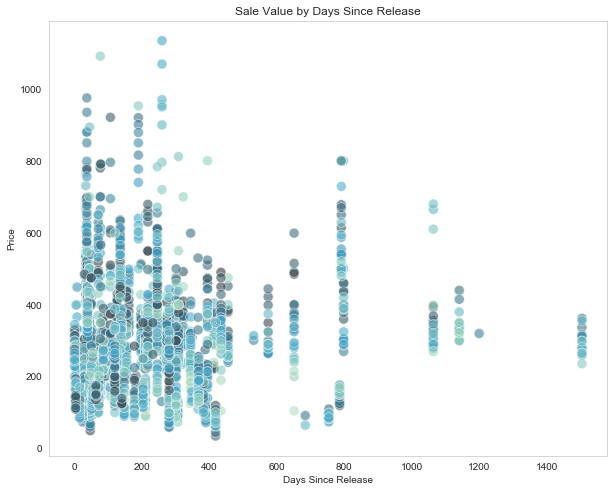

In [39]:
plot_df = df.copy()
plot_df = plot_df[plot_df['Sale Value'] < 1200]
sorting = sorted(plot_df['Size'].unique())
sorting = ['{:.1f}'.format(x) for x in sorting]

plot_df['Size'] = plot_df['Size'].astype(str)

sns.set_style("whitegrid", {'axes.grid' : False})
#sns.set(font_scale=2.5)

palette = sns.color_palette("GnBu_d", 29)
plt.figure(figsize=(10,8))

ax = sns.scatterplot(x = 'Days',y= 'Sale Value', data=plot_df, 
                     hue = 'Size', hue_order = sorting, 
                     palette=palette, legend = None, s=100,  alpha = 0.6)

ax.set_title('Sale Value by Days Since Release')
ax.set_xlabel('Days Since Release')
ax.set_ylabel('Price');

## # of Sales vs Sale Value (with Celeb Endorsement)

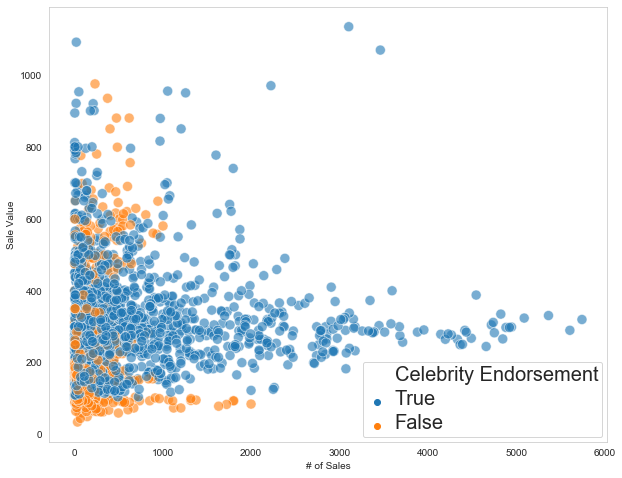

In [40]:
plot_df['Size'] = plot_df['Size'].astype(str)
plt.figure(figsize=(10,8))

ax = sns.scatterplot(x = '# of Sales',y= 'Sale Value', data=plot_df, hue_order = [True, False],
                     hue = 'Celebrity Endorsement', legend = 'brief', s=100,  alpha = 0.6)

# ax.set_title('Sale Value by Days Since Release')
# ax.set_xlabel('Days Since Release')
# ax.set_ylabel('Price');

plt.setp(ax.get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='20'); # for legend title;

# Modeling

## Train-Test Split
60-20-20

In [41]:
X_simple = df.loc[:, ['# of Sales', 'Retail Price', 'Volatility','Days','adidas','Jordan','Nike','Other','Celebrity Endorsement','TravisScott']]
y_simple = df['Sale Value']

#Split the data 60 - 20 - 20 train/val/test
X_train_val, X_test, y_train_val, y_test = train_test_split(X_simple, y_simple, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=40)

## Linear Model

In [42]:
linear = LinearRegression()
linear.fit(X_train,y_train)
pred_simple = linear.predict(X_test)
print('train: ' + str(r2_score(y_train, linear.predict(X_train))))
print('test: ' + str(r2_score(y_test, pred_simple)))

train: 0.3433704493266132
test: 0.3461544300589534


In [43]:
print('test: ' + str(r2_score(y_val, linear.predict(X_val))))

test: 0.3552294281141194


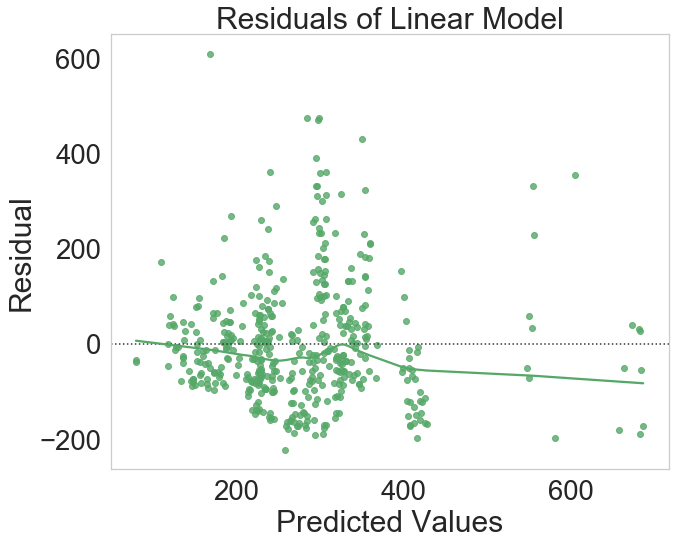

In [44]:
sns.set(font_scale=2.5)
sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=(10,8))
ax = sns.residplot(x = pred_simple, y = y_test - pred_simple, lowess=True, color = 'g')
ax.set_title('Residuals of Linear Model')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residual');

## Lasso Model

In [45]:
#make size dummies AFTER stripping column names (because they are numbers)
df['Size'] = df['Size'].astype(str)
size_dummies = pd.get_dummies(df['Size'],dummy_na=False,drop_first=True)
df = pd.concat([df, size_dummies], axis = 1)
#df.drop(['Size'], axis = 1,  inplace = True)

In [46]:
select_cols = ['Retail Price', '# of Sales', 
       'Days', 'Celebrity Endorsement', 'adidas', 'Jordan', 'Nike', 'TravisScott'] 
other_cols = ['Sale Value','Volatility']+ list(str(col) for col in size_dummies.columns)

In [47]:
#polynomials
pf = PolynomialFeatures(degree=2)
pf.fit(df[select_cols])
feat_array = pf.transform(df[select_cols])
modeling_df = pd.DataFrame(feat_array, columns = pf.get_feature_names(input_features=select_cols)).reset_index()
other_df = df[other_cols].reset_index()
modeling_df = pd.concat([other_df, modeling_df], axis = 1)
modeling_df.drop(['index', '1'], axis = 1,  inplace = True)

In [48]:
X = modeling_df.loc[:, modeling_df.columns != 'Sale Value']
y = df['Sale Value']

#Split the data 60 - 20 - 20 train/val/test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=40)

In [49]:
std = StandardScaler()
std.fit(X_train.values)
Xstd_train = std.transform(X_train.values)
Xstd_test = std.transform(X_test.values)
Xstd_val = std.transform(X_val.values)



#
Xstd_train_val = std.transform(X_train_val.values)

### Standardized Lasso

In [50]:
# for polynomial
lasso_model_std = Lasso(alpha = 0.01)

lasso_model_std.fit(Xstd_train,y_train)
test_set_pred2 = lasso_model_std.predict(Xstd_test)
print('train: ' + str(r2_score(y_train, lasso_model_std.predict(Xstd_train))))
print('test: ' + str(r2_score(y_test, test_set_pred2)))
print('validation: ' + str(r2_score(y_val, lasso_model_std.predict(Xstd_val))))

lasso_model_std.fit(Xstd_train_val,y_train_val)
print('train: ' + str(r2_score(y_train, lasso_model_std.predict(Xstd_train))))
print('test: ' + str(r2_score(y_test, lasso_model_std.predict(Xstd_test))))

train: 0.5755886556108147
test: 0.5436693871750231
validation: 0.5306212775640732
train: 0.5697817773565428
test: 0.5356440601293153


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4683348.586082309, tolerance: 3312.937573112869
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6305461.923146235, tolerance: 4424.941874609165
  positive)


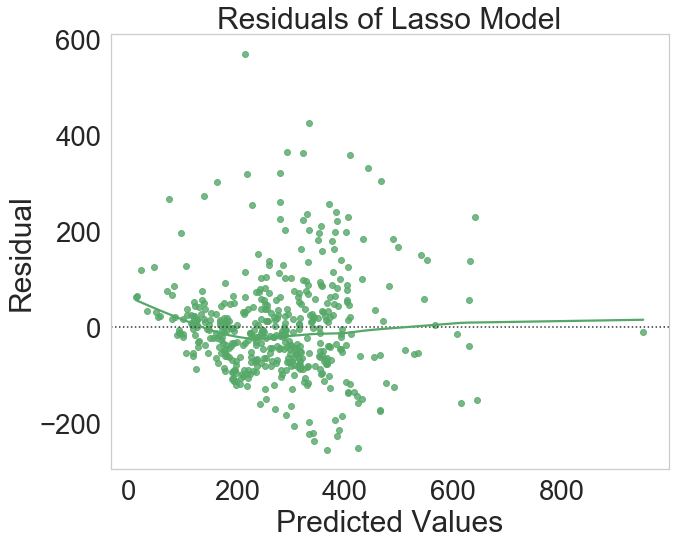

In [51]:
#sns.set(font_scale=2.5)
sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=(10,8))
ax = sns.residplot(x = test_set_pred2, y = y_test - test_set_pred2, lowess=True, color = 'g')
ax.set_title('Residuals of Lasso Model')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residual');

# Compare residuals

In [94]:
X_resid = X.copy()
X_resid['predicted'] = lasso_model_std.predict(std.transform(X_resid.values))
X_resid['actuals'] = y

X_resid= X_resid.merge(df, how = 'left')
X_resid['Potential'] = X_resid['predicted'] - X_resid['Sale Value'] 
X_resid[['Name','Size','Sale Value','# of Sales', 'predicted','Potential']].sort_values('Potential',ascending = False).head(15)

,Name,Size,Sale Value,# of Sales,predicted,Potential
646,Nike Blazer Mid 77 Vintage White Black,10.0,100,1318.0,453.005358,353.005358
769,Jordan 1 Retro High Travis Scott,15.0,720,252.0,1016.911684,296.911684
647,Nike Blazer Mid 77 Vintage White Black,10.5,94,1111.0,382.567274,288.567274
2028,Nike Vapor Street Off-White Black Laser Fuchsi...,6.5,124,73.0,410.737221,286.737221
2030,Nike Vapor Street Off-White Black Laser Fuchsi...,7.5,135,106.0,416.127518,281.127518
645,Nike Blazer Mid 77 Vintage White Black,9.5,97,1064.0,376.701235,279.701235
2029,Nike Vapor Street Off-White Black Laser Fuchsi...,7.0,144,98.0,419.415346,275.415346
2026,Nike Vapor Street Off-White Black Laser Fuchsi...,5.5,120,38.0,393.607617,273.607617
2038,Nike Vapor Street Off-White Black Laser Fuchsi...,11.5,124,148.0,379.196845,255.196845
2027,Nike Vapor Street Off-White Black Laser Fuchsi...,6.0,160,50.0,410.723207,250.723207


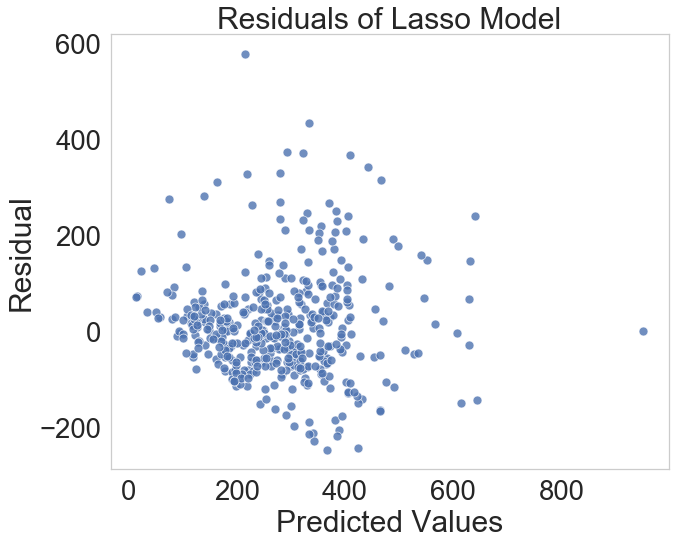

In [95]:
plt.figure(figsize=(10,8))
ax = sns.scatterplot(x = test_set_pred2, y = y_test - test_set_pred2, s = 80, alpha = 0.8)
ax.set_title('Residuals of Lasso Model')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residual');

In [96]:
features=(list(zip(modeling_df.columns[1:], lasso_model_std.coef_)))
features = pd.DataFrame(features, columns = ['feature','coeff'])

In [97]:
features.sort_values('coeff', ascending = False, inplace = True)
features.head(10)

,feature,coeff
29,Retail Price,186.171176
40,Retail Price Celebrity Endorsement,89.321123
53,Days Celebrity Endorsement,88.789910
57,Days TravisScott,75.501875
59,Celebrity Endorsement adidas,67.814181
63,adidas^2,67.166172
44,Retail Price TravisScott,65.415629
43,Retail Price Nike,62.899824
34,Jordan,58.117706
30,# of Sales,57.457046


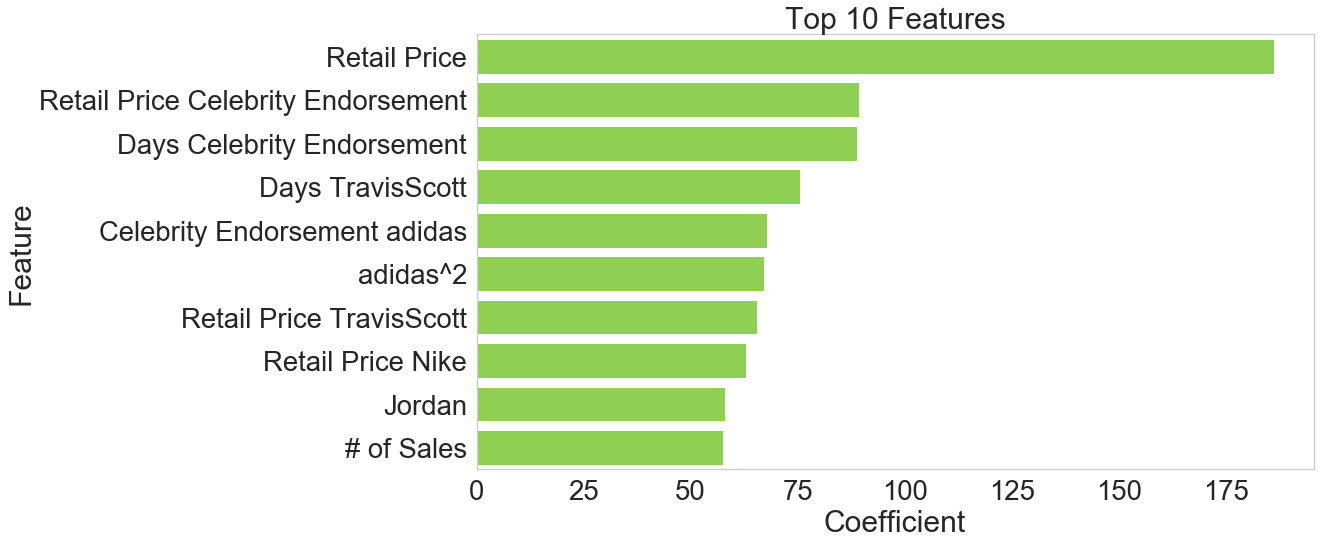

In [98]:
plt.figure(figsize=(15,8))
sns.set(font_scale=2.5)
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.barplot(x = 'coeff', y = 'feature', orient = 'h', data= features.head(10), color = '#8ee53f')
ax.set_title('Top 10 Features')
ax.set_xlabel('Coefficient')
ax.set_ylabel('Feature');

# Random forest

In [54]:
regressor = RandomForestRegressor(n_estimators=20, random_state=42)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [55]:
r2_score(y_test, y_pred)

0.750746229016172

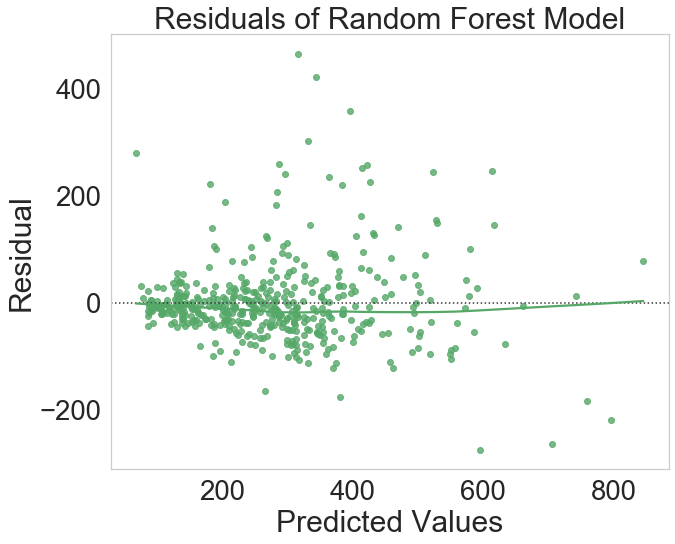

In [58]:
sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=(10,8))
ax = sns.residplot(x = y_pred, y = y_test - y_pred, lowess=True, color = 'g')
ax.set_title('Residuals of Random Forest Model')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residual');

In [60]:
importances = pd.DataFrame(zip(modeling_df.columns[1:], regressor.feature_importances_), columns = ['Feature','Importance'])

In [63]:
importances.sort_values('Importance', ascending=False).head(10)

,Feature,Importance
37,Retail Price^2,0.098493
29,Retail Price,0.096997
59,Celebrity Endorsement adidas,0.087180
0,Volatility,0.071235
50,# of Sales Nike,0.070151
44,Retail Price TravisScott,0.065475
46,# of Sales Days,0.045368
39,Retail Price Days,0.040641
43,Retail Price Nike,0.038539
38,Retail Price # of Sales,0.029377


In [67]:
importances_bar_df = importances.sort_values('Importance', ascending=False).head(10)

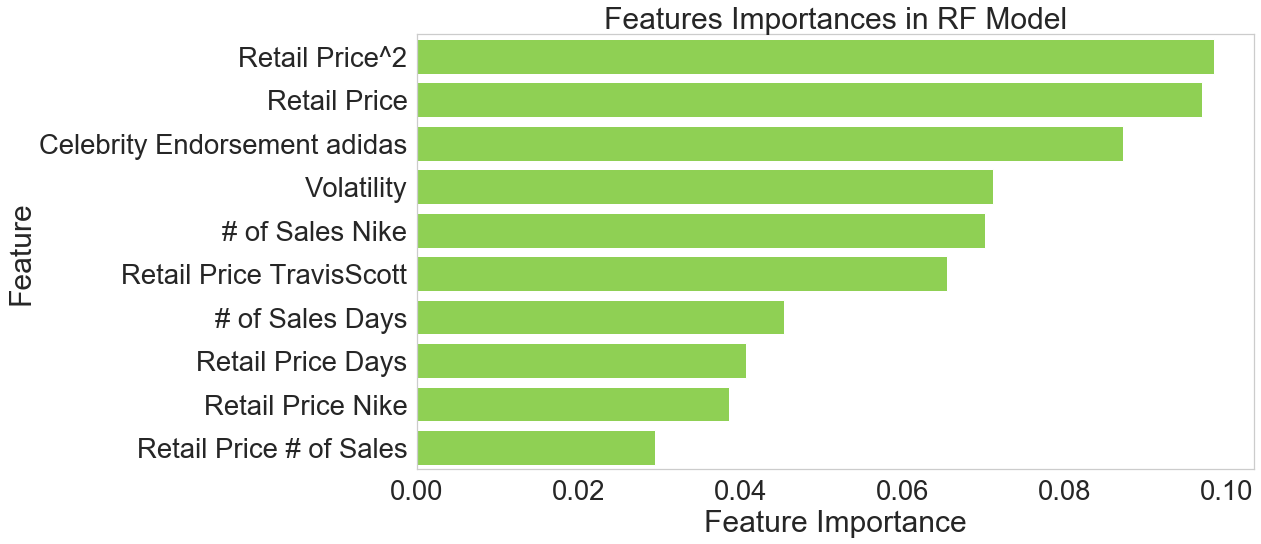

In [70]:
plt.figure(figsize=(15,8))
sns.set(font_scale=2.5)
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.barplot(x = 'Importance', y = 'Feature', orient = 'h', data= importances_bar_df, color = '#8ee53f')
ax.set_title('Features Importances in RF Model')
ax.set_ylabel('Feature')
ax.set_xlabel('Feature Importance');